In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.io import FixedLenFeature 
from tensorflow.train import Features, Feature, Example, BytesList, Int64List
from tensorflow.data import Dataset, TFRecordDataset 
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential

!pip install -q efficientnet
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets

import random
import os
import gc
import datetime

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
BATCH_SIZE = 128
IMG_DIM = 512
IMG_SIZE = [IMG_DIM, IMG_DIM]

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() 
GCS_PATH_SELECT = { 
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
IMAGE_SIZE = [IMG_DIM, IMG_DIM] 
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

In [5]:
filenames_train = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
filenames_valid = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
filenames_test = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

In [6]:
def image_decode(image):

    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMG_SIZE, 3])

    return image

In [7]:
def read_Labeled_TFRecord(dataset):
    features = {
                'image': FixedLenFeature([], tf.string),
                'id': FixedLenFeature([], tf.string),
                'class': FixedLenFeature([], tf.int64)
                }
    example = tf.io.parse_single_example(dataset, features=features)
    image = image_decode(example['image'])
    label = tf.cast(example['class'], tf.int32)

    return image, label

In [8]:
def read_Unlabeled_TFRecord(dataset):
    features = {
                'image': FixedLenFeature([], tf.string),
                'id': FixedLenFeature([], tf.string)
                }
    example = tf.io.parse_single_example(dataset, features=features)
    idnum = image_decode(example['image'])
    image = example['id']

    return image, idnum

In [9]:
def load_data_train(filename):
    
    dataset = TFRecordDataset(filename)
    dataset = dataset.map(read_Labeled_TFRecord)
    dataset = dataset.shuffle(buffer_size = len(filename))
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [10]:
def load_data_val_test(filename, labeled = True):
    
    dataset = TFRecordDataset(filename)
    dataset = dataset.map(read_Labeled_TFRecord if labeled else read_Unlabeled_TFRecord)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [11]:
def get_weights(filenames):
    """
    Count the repetition rate of each label and adjust its weight
    """
    dataset = TFRecordDataset(filenames)
    dataset = dataset.map(read_Labeled_TFRecord)
    train_lb = []
    for img, lbel in dataset:
        train_lb.append(lbel.numpy())
    total_num = len(train_lb)
    # count the number of times each label is repeated
    uniq, cnts = np.unique(train_lb, return_counts=1)
    weights = {}
    for i, key in enumerate(uniq):
        weights[key] = 1/cnts[i]*total_num/len(uniq) 
    
    return weights

In [12]:
train_data = load_data_train(filenames_train)
valid_data = load_data_val_test(filenames_valid)
test_data = load_data_val_test(filenames_valid, labeled = False)
class_weights = get_weights(filenames_train)

In [13]:
 dataset = TFRecordDataset(filenames_train)
 dataset = dataset.map(read_Labeled_TFRecord)

In [14]:
#for example in tf.compat.v1.io.tf_record_iterator('data\\tfrecords-jpeg-192x192\\train\\00-192x192-798.tfrec'):
#   result = tf.train.Example.FromString(example)
#   print(result.features.feature['class'])

In [15]:
def show_8_images(dataset):

    rnd_num = random.randint(1, BATCH_SIZE)
    for IMG, label in dataset.take(rnd_num):
         Example_image = IMG
         Example_label = label

    plt.figure(figsize= (10, 5))
    for i in range(8):
         ax = plt.subplot(2, 4, i+1)
         plt.imshow(Example_image[i])
         plt.title(Example_label[i].numpy())
         plt.axis('off')

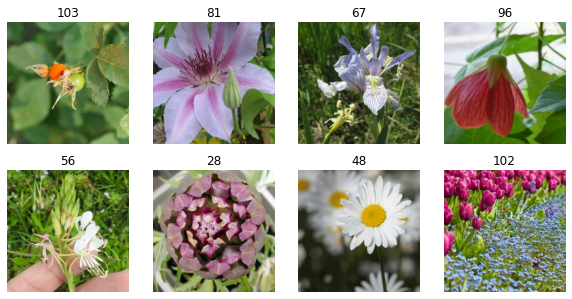

In [16]:
show_8_images(valid_data)

# Creating and training a model

In [17]:
INPUT_SHAPE = [IMG_DIM, IMG_DIM, 3]
OUTPUT_SIZE = 104

In [18]:
def create_model(pretrained = False):
    model = []
    if pretrained:
        files = os.listdir('models')
        paths = [os.path.join('models/', basename) for basename in files]
        model_path = max(paths, key = os.path.getctime)
    else:
        with strategy.scope():
            img_inp = Input(shape = INPUT_SHAPE, name= 'img_inp')
            efnB3 = efn.EfficientNetB3(weights = 'imagenet', include_top = False)
            x = efnB3(img_inp)
            x = GlobalAveragePooling2D()(x)
            outputs = Dense(OUTPUT_SIZE, activation = 'softmax')(x)
    
            model = tf.keras.models.Model(inputs = img_inp, outputs = outputs)
            #model = Sequential([
            #                    efnB3,
            #                    GlobalAveragePooling2D(),
            #                    Dense(OUTPUT_SIZE, activation = 'softmax')])
            
            model.compile(
                optimizer = tf.keras.optimizers.SGD(lr = 1e-1),
                loss = 'sparse_categorical_crossentropy',
                metrics = 'sparse_categorical_accuracy')
            
            model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
            
    return model

In [19]:
model = create_model()
#tf.keras.utils.plot_model(model, show_shapes=True)

44113920/44107200 [==============================] - 1s 0us/step


In [20]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 4)
Rate = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, verbose = 0, mode = 'auto', cooldown = 0, min_lr= 1e-6)

In [21]:
NUM_EPOCH = 100
gc.collect()

40

In [22]:
history = model.fit(train_data, epochs = NUM_EPOCH, validation_data= valid_data, validation_freq= 1, callbacks = [EarlyStopping, Rate], class_weight=class_weights)

Epoch 1/100
100/100 [==============================] - 113s 1s/step - loss: 3.3329 - sparse_categorical_accuracy: 0.2509 - val_loss: 2.7129 - val_sparse_categorical_accuracy: 0.3755 - lr: 0.1000
Epoch 2/100
100/100 [==============================] - 64s 636ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.6507 - val_loss: 1.2781 - val_sparse_categorical_accuracy: 0.7120 - lr: 0.1000
Epoch 3/100
100/100 [==============================] - 63s 634ms/step - loss: 0.6770 - sparse_categorical_accuracy: 0.7914 - val_loss: 0.8076 - val_sparse_categorical_accuracy: 0.8211 - lr: 0.1000
Epoch 4/100
100/100 [==============================] - 63s 633ms/step - loss: 0.4710 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.8570 - lr: 0.1000
Epoch 5/100
100/100 [==============================] - 63s 632ms/step - loss: 0.3590 - sparse_categorical_accuracy: 0.8739 - val_loss: 0.5221 - val_sparse_categorical_accuracy: 0.8812 - lr: 0.1000
Epoch 6/100
100/1

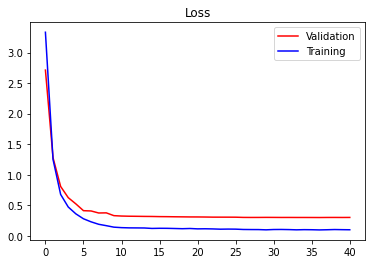

In [23]:
plt.plot(history.history['val_loss'], color = 'red')
plt.plot(history.history['loss'], color = 'blue')
plt.legend(['Validation', 'Training'])
plt.title('Loss')
plt.show()

In [24]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
NUM_TEST_IMAGES = 7382
print('Computing predictions...')
test_images_ds = test_data.map(lambda idnum, image: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_data.map(lambda idnum, image: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id,label', comments = '')

Computing predictions...


In [ ]:
sfx = "EfficientNet3B"
model.save('model.h5')
#save_model(model, suffix=sfx)